# Modelo Prophet

In [1]:
# Instalar a biblioteca Prophet
# %pip install prophet

In [2]:
# Bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import classification_report, accuracy_score
import warnings

warnings.filterwarnings("ignore")

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
# Carregar os dados
df = pd.read_csv('Dados_Historicos_Ibovespa.csv', sep=',')
df

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.10.2025,149.540,148.774,149.636,148.774,"8,91B","0,51%"
1,30.10.2025,148.780,148.632,149.234,147.546,"7,30B","0,10%"
2,29.10.2025,148.633,147.430,149.067,147.430,"8,00B","0,82%"
3,28.10.2025,147.429,146.970,147.811,146.575,"7,11B","0,31%"
4,27.10.2025,146.969,146.174,147.977,146.174,"6,45B","0,55%"
...,...,...,...,...,...,...,...
747,07.11.2022,115.342,118.148,118.240,115.221,"15,22M","-2,38%"
748,04.11.2022,118.155,116.907,120.039,116.904,"16,21M","1,08%"
749,03.11.2022,116.896,116.927,117.373,114.485,"15,63M","-0,03%"
750,01.11.2022,116.929,116.037,118.261,115.547,"17,97M","0,77%"


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      752 non-null    object 
 1   Último    752 non-null    float64
 2   Abertura  752 non-null    float64
 3   Máxima    752 non-null    float64
 4   Mínima    752 non-null    float64
 5   Vol.      752 non-null    object 
 6   Var%      752 non-null    object 
dtypes: float64(4), object(3)
memory usage: 41.3+ KB


In [34]:
df['Último'] = df['Último'].apply(lambda x: f"{x:,.3f}".replace(".", "X").replace(",", ".").replace("X", "")).astype(float)
df['Abertura'] = df['Abertura'].apply(lambda x: f"{x:,.3f}".replace(".", "X").replace(",", ".").replace("X", "")).astype(float)
df['Máxima'] = df['Máxima'].apply(lambda x: f"{x:,.3f}".replace(".", "X").replace(",", ".").replace("X", "")).astype(float)
df['Mínima'] = df['Mínima'].apply(lambda x: f"{x:,.3f}".replace(".", "X").replace(",", ".").replace("X", "")).astype(float)

In [24]:
# Convertendo a coluna Data para formato datetime
df['Data'] = pd.to_datetime(df['Data'], format='%d.%m.%Y')
df = df.sort_values(by="Data", ascending=True).reset_index(drop=True)

In [35]:
# Convertendo a coluna 'Vol.' para valores numéricos
def convert_volume(volume_str):
    if isinstance(volume_str, str):
        volume_str = volume_str.replace(',', '.').strip()
        if 'B' in volume_str:
            return float(volume_str.replace('B', '')) * 1000000000
        elif 'M' in volume_str:
            return float(volume_str.replace('M', '')) * 1000000
        elif 'K' in volume_str:
            return float(volume_str.replace('K', '')) * 1000
        else:
            return float(volume_str)
    return volume_str

df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Vol.'] = pd.to_numeric(df['Vol.'], errors='coerce')

In [36]:
# Converter valores em Var%
df['Var%'] = df['Var%'].str.replace('%', '', regex=False)
df['Var%'] = df['Var%'].str.replace(',', '.', regex=False)
df['Var%'] = pd.to_numeric(df['Var%'], errors='coerce')
df['Var%'] = df['Var%'] / 100

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      752 non-null    object 
 1   Último    752 non-null    float64
 2   Abertura  752 non-null    float64
 3   Máxima    752 non-null    float64
 4   Mínima    752 non-null    float64
 5   Vol.      752 non-null    float64
 6   Var%      752 non-null    float64
dtypes: float64(6), object(1)
memory usage: 41.3+ KB


### Algoritmo Prophet

O Prophet exige que o DataFrame tenha exatamente duas colunas principais: `ds` e `y`. Sendo:
* `ds`: do tipo `datetime`, ou seja, do tipo data
* `y`: valores numéricos, do tipo `float` (o que queremos prever)

In [38]:
# Renomeando as colunas para o formato esperado pelo Prophet
df = df[['Data', 'Último', 'Vol.', 'Abertura']].rename(columns={'Data': 'ds', 'Último': 'y', 'Vol.': 'volume', 'Abertura': 'open'})

# Ordenar por data
df = df.sort_values('ds')

# Divisão Treino/Teste
train = df.iloc[:-30]
test = df.iloc[-30:]

### Prophet Simples
Aqui é testado o modelo simples, considerando somente o preço e as datas

In [11]:
# Configuração do Modelo
model = Prophet(
    changepoint_prior_scale=0.05, 
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False 
)
model.add_country_holidays(country_name='BR')

model.fit(train)

# Previsão
forecast = model.predict(test[['ds', 'y']])

17:05:53 - cmdstanpy - INFO - Chain [1] start processing
17:05:55 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
# Avaliação de Acurácia Direcional (Sobe/Desce)
test_results = test.copy()
test_results['yhat'] = forecast['yhat'].values
test_results['prev_y'] = df['y'].shift(1).iloc[-30:].values
test_results['mov_real'] = (test_results['y'] > test_results['prev_y']).astype(int)
test_results['mov_pred'] = (test_results['yhat'] > test_results['prev_y']).astype(int)

acc = accuracy_score(test_results['mov_real'], test_results['mov_pred'])
print(f"\nAcurácia Direcional Real: {acc:.2%}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(test_results['mov_real'], test_results['mov_pred']))


Acurácia Direcional Real: 63.33%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.67      0.78      0.72        18

    accuracy                           0.63        30
   macro avg       0.61      0.60      0.60        30
weighted avg       0.62      0.63      0.62        30



### Prophet com Volume como Regressor
Utilizei o volume como regressor para verificar correlação entre o fluxo financeiro e o preço.

In [13]:
# Configuração do Modelo
model = Prophet(
    changepoint_prior_scale=0.05, 
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False 
)
model.add_country_holidays(country_name='BR')
model.add_regressor('volume')

model.fit(train)

# Previsão
forecast = model.predict(test[['ds', 'volume']])

17:05:56 - cmdstanpy - INFO - Chain [1] start processing
17:05:59 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
# Avaliação de Acurácia Direcional (Sobe/Desce)
test_results = test.copy()
test_results['yhat'] = forecast['yhat'].values
test_results['prev_y'] = df['y'].shift(1).iloc[-30:].values
test_results['mov_real'] = (test_results['y'] > test_results['prev_y']).astype(int)
test_results['mov_pred'] = (test_results['yhat'] > test_results['prev_y']).astype(int)

acc = accuracy_score(test_results['mov_real'], test_results['mov_pred'])
print(f"\nAcurácia Direcional Real: {acc:.2%}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(test_results['mov_real'], test_results['mov_pred']))


Acurácia Direcional Real: 63.33%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.56      0.42      0.48        12
           1       0.67      0.78      0.72        18

    accuracy                           0.63        30
   macro avg       0.61      0.60      0.60        30
weighted avg       0.62      0.63      0.62        30



*A acurácia do simples e com volume são iguais mesmo?* 

**Comparação gráfica entre Real vs. Previsto**

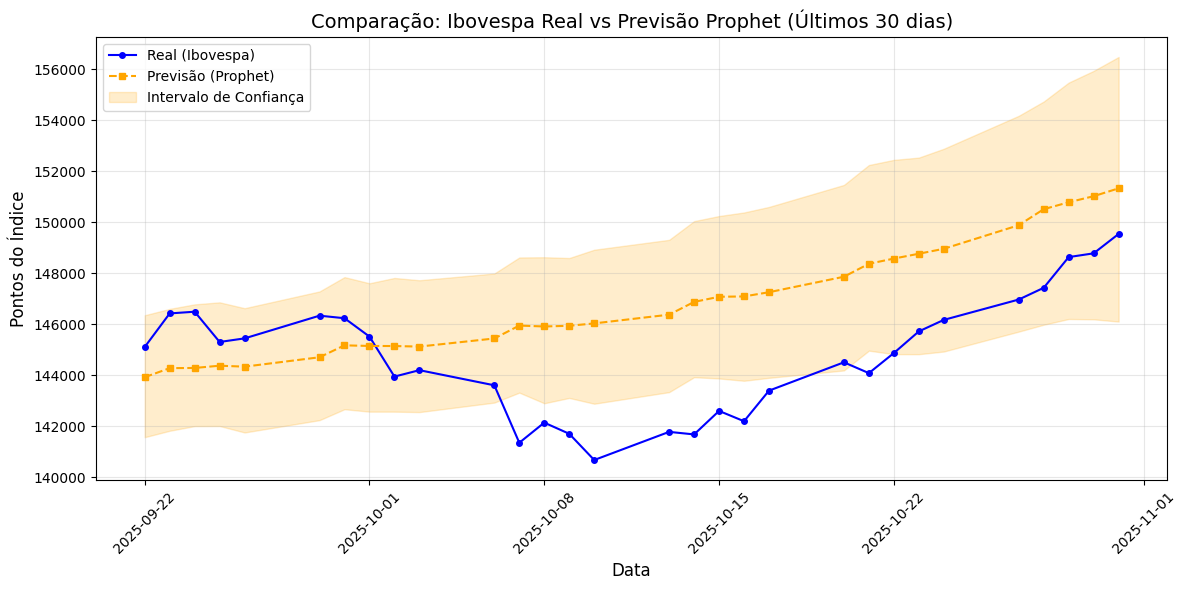

In [15]:
# Preparando os dados para o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(test['ds'], test['y'], label='Real (Ibovespa)', color='blue', marker='o', markersize=4)

# Plotar os valores previstos
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão (Prophet)', color='orange', linestyle='--', marker='s', markersize=4)

# Preencher a área de incerteza (Intervalo de Confiança)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='orange', alpha=0.2, label='Intervalo de Confiança')

# Customização do gráfico
plt.title('Comparação: Ibovespa Real vs Previsão Prophet (Últimos 30 dias)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Pontos do Índice', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

*O gráfico está apresentando muitos pontos fora do intervalo de confiança.*

### Prophet com Lag no Volume como Regressor
Aqui utilizei o lag para verificar o volume de "ontem" para prever o preço de "hoje".

In [16]:
# Criamos o volume de ontem para prever o preço de hoje
df['volume_lag1'] = df['volume'].shift(1)

# Removemos a primeira linha que ficou vazia após o shift
df = df.dropna(subset=['volume_lag1'])

# Preparar colunas para o Prophet
df_prophet = df[['ds', 'y', 'volume_lag1']]

# Divisão Treino/Teste
train = df_prophet.iloc[:-30]
test = df_prophet.iloc[-30:]

# Configuração e Treino do Modelo
model = Prophet(
    changepoint_prior_scale=0.05,
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.add_country_holidays(country_name='BR')
model.add_regressor('volume_lag1') # Adicionando o Volume de Ontem como regressor
model.fit(train)

# Previsão
forecast = model.predict(test)


17:06:00 - cmdstanpy - INFO - Chain [1] start processing
17:06:03 - cmdstanpy - INFO - Chain [1] done processing


In [17]:
# Avaliação de Acurácia Direcional com Lagged Volume
test_results = test.copy()
test_results['yhat'] = forecast['yhat'].values
test_results['preco_ontem'] = df['y'].shift(1).iloc[-30:].values
test_results['mov_real'] = (test_results['y'] > test_results['preco_ontem']).astype(int)
test_results['mov_pred'] = (test_results['yhat'] > test_results['preco_ontem']).astype(int)

acc = accuracy_score(test_results['mov_real'], test_results['mov_pred'])
print(f"\nAcurácia Direcional com Lagged Volume: {acc:.2%}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(test_results['mov_real'], test_results['mov_pred']))


Acurácia Direcional com Lagged Volume: 60.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        12
           1       0.67      0.67      0.67        18

    accuracy                           0.60        30
   macro avg       0.58      0.58      0.58        30
weighted avg       0.60      0.60      0.60        30



**Comparação gráfica entre Real vs. Previsto (Lagged Volume)**

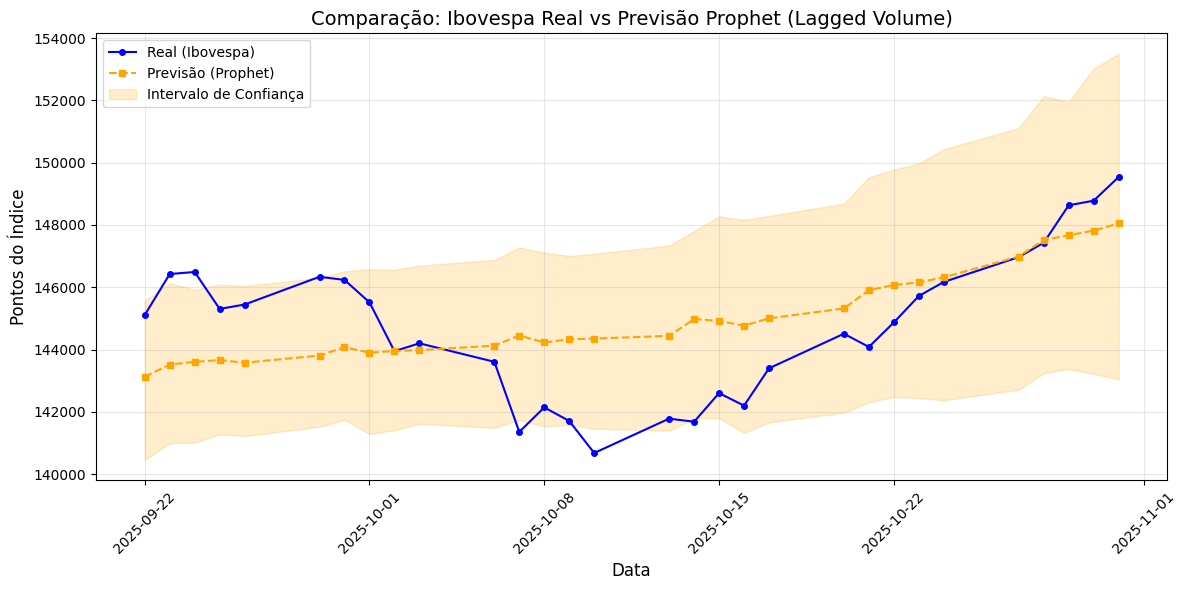

In [18]:
# Preparando os dados para o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(test['ds'], test['y'], label='Real (Ibovespa)', color='blue', marker='o', markersize=4)

# Plotar os valores previstos
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão (Prophet)', color='orange', linestyle='--', marker='s', markersize=4)

# Preencher a área de incerteza (Intervalo de Confiança)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='orange', alpha=0.2, label='Intervalo de Confiança')

# Customização do gráfico
plt.title('Comparação: Ibovespa Real vs Previsão Prophet (Lagged Volume)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Pontos do Índice', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Utilizando Abertura como Regressor

In [39]:
df

,ds,y,volume,open
687,01.02.2023,112074.0,1.782000e+07,113430.0
439,01.02.2024,128481.0,1.023000e+07,127752.0
669,01.03.2023,104385.0,1.985000e+07,104933.0
420,01.03.2024,129180.0,9.770000e+06,129026.0
400,01.04.2024,126990.0,9.370000e+06,128106.0
...,...,...,...,...
542,31.08.2023,115742.0,1.295000e+07,117537.0
751,31.10.2022,116037.0,2.164000e+07,114533.0
501,31.10.2023,113144.0,1.056000e+07,112534.0
249,31.10.2024,129713.0,9.070000e+06,130639.0


In [40]:
# Renomeando as colunas para o formato esperado pelo Prophet
df_open = df[['ds', 'y', 'open']].copy()

# Ordenar por data
df_open = df_open.sort_values('ds')

# Divisão Treino/Teste
train = df_open.iloc[:-30]
test = df_open.iloc[-30:]

In [42]:
# Configuração do Modelo
model = Prophet(
    changepoint_prior_scale=0.05, 
    seasonality_mode='multiplicative',
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False 
)
model.add_country_holidays(country_name='BR')
model.add_regressor('open')

train['ds'] = pd.to_datetime(train['ds'], format='%d.%m.%Y')
model.fit(train)

# Previsão
forecast = model.predict(test[['ds', 'open']])

17:29:43 - cmdstanpy - INFO - Chain [1] start processing
17:29:44 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
# Avaliação de Acurácia Direcional (Sobe/Desce)
test_results = test.copy()
test_results['yhat'] = forecast['yhat'].values
test_results['prev_y'] = df['y'].shift(1).iloc[-30:].values
test_results['mov_real'] = (test_results['y'] > test_results['prev_y']).astype(int)
test_results['mov_pred'] = (test_results['yhat'] > test_results['prev_y']).astype(int)

acc = accuracy_score(test_results['mov_real'], test_results['mov_pred'])
print(f"\nAcurácia Direcional Real: {acc:.2%}")

# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(test_results['mov_real'], test_results['mov_pred']))


Acurácia Direcional Real: 70.00%

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.69      0.64      0.67        14
           1       0.71      0.75      0.73        16

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



TypeError: tz must be string or tzinfo subclass, not <matplotlib.category.UnitData object at 0x000002761ED68170>.

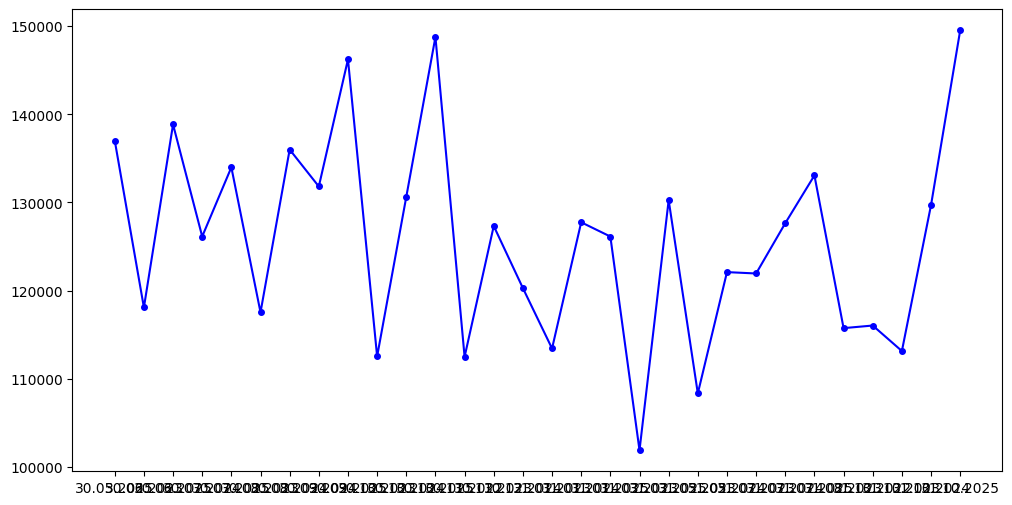

In [46]:
# Preparando os dados para o gráfico
plt.figure(figsize=(12, 6))

# Plotar os valores reais
plt.plot(test['ds'], test['y'], label='Real (Ibovespa)', color='blue', marker='o', markersize=4)

# Plotar os valores previstos
plt.plot(forecast['ds'], forecast['yhat'], label='Previsão (Prophet)', color='orange', linestyle='--', marker='s', markersize=4)

# Preencher a área de incerteza (Intervalo de Confiança)
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], 
                 color='orange', alpha=0.2, label='Intervalo de Confiança')

# Customização do gráfico
plt.title('Comparação: Ibovespa Real vs Previsão Prophet (Lagged Volume)', fontsize=14)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Pontos do Índice', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()